In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import calendar

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.formula.api import rlm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

import plotly.express as px
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.subplots as sp
import plotly.graph_objs as go

import gdown
import os
import time
import warnings
from contextlib import redirect_stdout

In [ ]:
# Download the CSV file using the file ID
url = f'https://drive.google.com/uc?id=1oWPJOhXGiLn-c-4c2Pk86QKtI4OMedo-'
output = '/content/data.csv'
gdown.download(url, output, quiet=False)

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(output)


Downloading...
From: https://drive.google.com/uc?id=1oWPJOhXGiLn-c-4c2Pk86QKtI4OMedo-
To: /content/data.csv
100%|██████████| 3.37M/3.37M [00:00<00:00, 64.0MB/s]


In [ ]:
print(df.head())
print(df.columns)


  Start_of_Interval   End_of_Interval   PM10  PM2.5  Air_Temp  Wind_Dir  \
0  01-01-2019 00:00  01-01-2019 01:00  16.20    NaN      20.0     219.0   
1  01-01-2019 01:00  01-01-2019 02:00  18.95    NaN      19.5     217.0   
2  01-01-2019 02:00  01-01-2019 03:00  24.20    NaN      19.0     219.0   
3  01-01-2019 03:00  01-01-2019 04:00  22.80    NaN      19.5     219.5   
4  01-01-2019 04:00  01-01-2019 05:00  19.70    NaN      20.0     218.5   

   Wind_Speed  Rel_Humidity  Solar_Rad  NO   NO2   Nox  SO2   Lag1   Lag2  
0        3.05         78.10        NaN NaN   NaN   NaN  NaN    NaN    NaN  
1        2.80         78.95        NaN NaN   NaN   NaN  NaN  16.20    NaN  
2        2.45         79.85        NaN NaN  5.30  8.20  NaN  18.95  16.20  
3        2.30         79.90        NaN NaN  4.65  6.45  NaN  24.20  18.95  
4        2.70         78.90        NaN NaN  4.15  5.70  NaN  22.80  24.20  
Index(['Start_of_Interval', 'End_of_Interval', 'PM10', 'PM2.5', 'Air_Temp',
       'Wind_Dir'

In [ ]:
df=df.drop('Solar_Rad',axis=1)

Dealing with negative, NaN values and outliers

In [ ]:
  df.isnull().sum()

Start_of_Interval       2
End_of_Interval         2
PM10                 2109
PM2.5                6704
Air_Temp             2629
Wind_Dir             3795
Wind_Speed           2721
Rel_Humidity         2483
NO                   4625
NO2                  4346
Nox                  4509
SO2                  4568
Lag1                 2109
Lag2                 2109
dtype: int64

In [ ]:
numeric_cols = df.select_dtypes(include=np.number)

# Replace negative values with NaN in numeric columns
df[numeric_cols.columns] = numeric_cols.mask(numeric_cols < 0)


In [ ]:
df.describe()

,PM10,PM2.5,Air_Temp,Wind_Dir,Wind_Speed,Rel_Humidity,NO,NO2,Nox,SO2,Lag1,Lag2
count,34238.000000,28457.000000,33853.000000,32687.000000,33761.000000,33999.000000,30960.000000,31982.000000,31862.000000,28944.000000,34238.000000,34238.000000
mean,14.504921,6.164362,16.611024,179.754291,2.808245,69.973962,10.926995,14.691791,25.264431,1.044762,14.504921,14.504921
std,7.566658,4.171656,3.927850,89.011437,1.550103,12.258790,20.956284,12.594481,30.583754,1.425919,7.566658,7.566658
min,0.000000,0.000000,3.000000,3.000000,0.250000,28.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.250000,3.500000,14.000000,94.000000,1.550000,60.900000,1.150000,4.650000,6.250000,0.300000,9.250000,9.250000
50%,13.550000,5.450000,16.500000,213.000000,2.550000,70.850000,4.300000,11.200000,16.100000,0.700000,13.550000,13.550000
75%,18.537500,7.900000,19.500000,236.500000,3.850000,79.950000,12.200000,21.350000,32.700000,1.200000,18.537500,18.537500
max,187.450000,93.950000,28.000000,356.000000,7.900000,98.800000,324.600000,81.300000,387.600000,22.200000,187.450000,187.450000


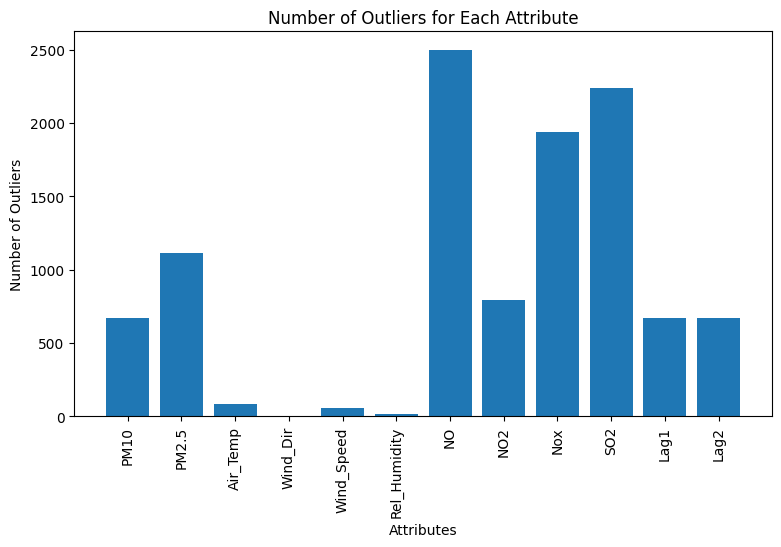

In [ ]:
outlier_counts = {}

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

plt.figure(figsize=(9, 5))
plt.bar(range(len(outlier_counts)), list(outlier_counts.values()), align='center')
plt.xticks(range(len(outlier_counts)), list(outlier_counts.keys()), rotation='vertical')
plt.xlabel('Attributes')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers for Each Attribute')
plt.show()

In [ ]:
columns_to_winsorize = ['PM10', 'PM2.5', 'NO', 'NO2', 'Nox', 'SO2', 'Lag1', 'Lag2']

# Calculate robust Z-score for each column
median = df[columns_to_winsorize].median()
mad = df[columns_to_winsorize].mad()
z_scores = 0.6745 * (df[columns_to_winsorize] - median) / mad

# Set a threshold for the Z-score
threshold = 1

df[columns_to_winsorize] = np.where(np.abs(z_scores) > threshold, np.nan, df[columns_to_winsorize])
df['NO'] = np.where(np.abs(z_scores['NO']) > 0.7, np.nan, df['NO'])

In [ ]:
# Handle NaN values using KNNImputer
# We specify the nearest neighbor to be 3
fea_transformer = KNNImputer(n_neighbors=3)
values = fea_transformer.fit_transform(df.iloc[:, 2:])
pm10 = pd.DataFrame(values, columns=df.columns[2:])
print(pm10)

            PM10     PM2.5   Air_Temp    Wind_Dir  Wind_Speed  Rel_Humidity  \
0      16.200000  5.266667  20.000000  219.000000    3.050000     78.100000   
1      18.950000  5.650000  19.500000  217.000000    2.800000     78.950000   
2      18.533333  6.383333  19.000000  219.000000    2.450000     79.850000   
3      13.966667  7.233333  19.500000  219.500000    2.300000     79.900000   
4      19.700000  5.750000  20.000000  218.500000    2.700000     78.900000   
...          ...       ...        ...         ...         ...           ...   
36477   6.150000  4.650000  10.000000  213.833333    0.666667     87.066667   
36478  13.850000  5.800000  18.666667  223.666667    0.883333     79.900000   
36479  15.150000  8.650000  18.000000  233.000000    1.400000     85.050000   
36480  14.650000  5.783333  20.333333  156.666667    3.050000     62.150000   
36481  16.483333  6.150000  23.333333  162.666667    3.966667     60.100000   

             NO        NO2        Nox       SO2    

In [ ]:
df2=df.copy()
df2[numeric_cols.columns] = pm10.values

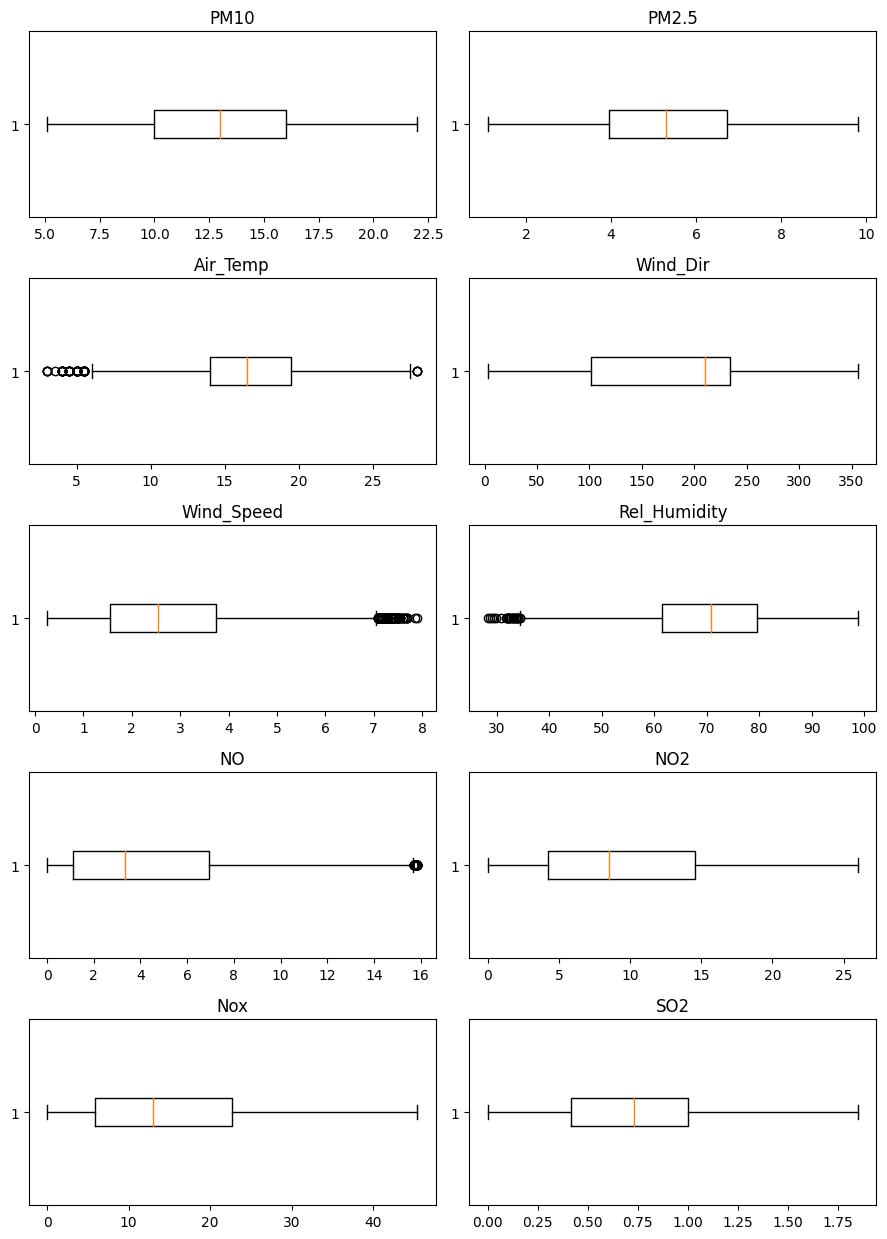

In [ ]:
import matplotlib.pyplot as plt

columns_to_visualize = ['PM10', 'PM2.5', 'Air_Temp', 'Wind_Dir', 'Wind_Speed', 'Rel_Humidity', 'NO', 'NO2', 'Nox', 'SO2']
num_columns = len(columns_to_visualize)
num_rows = (num_columns + 1) // 2

# Calculate the figure size based on the desired grid size
fig_width = 9
fig_height = 2.5 * num_rows

# Create a figure and axes for the subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(fig_width, fig_height))

# Iterate over each column and create box plots
for i, column in enumerate(columns_to_visualize):
    # Calculate the subplot position in the grid
    row = i // 2  # Determine the row position
    col = i % 2   # Determine the column position

    # Create a box plot for the current column in the appropriate subplot
    axs[row, col].boxplot(df2[column], vert=False)
    axs[row, col].set_title(column)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


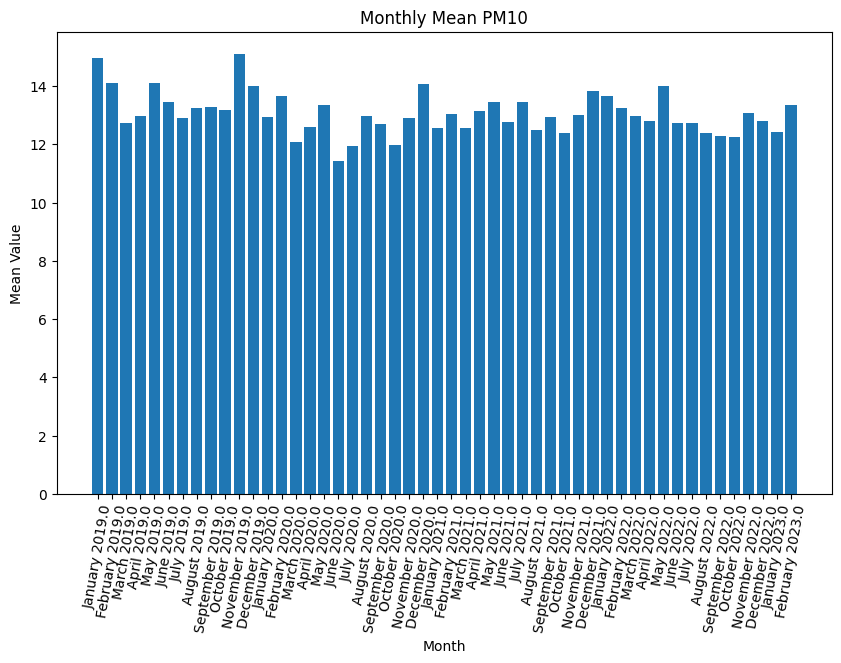

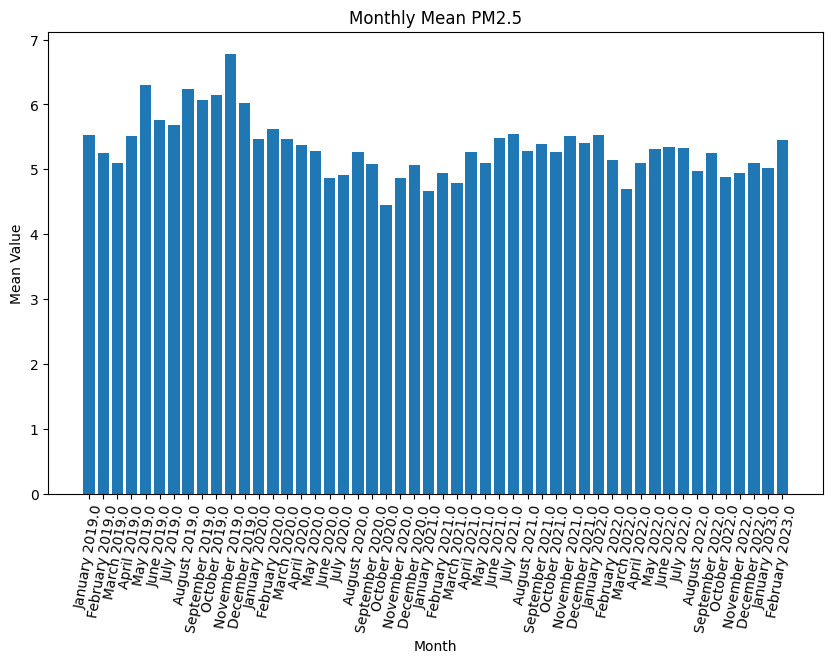

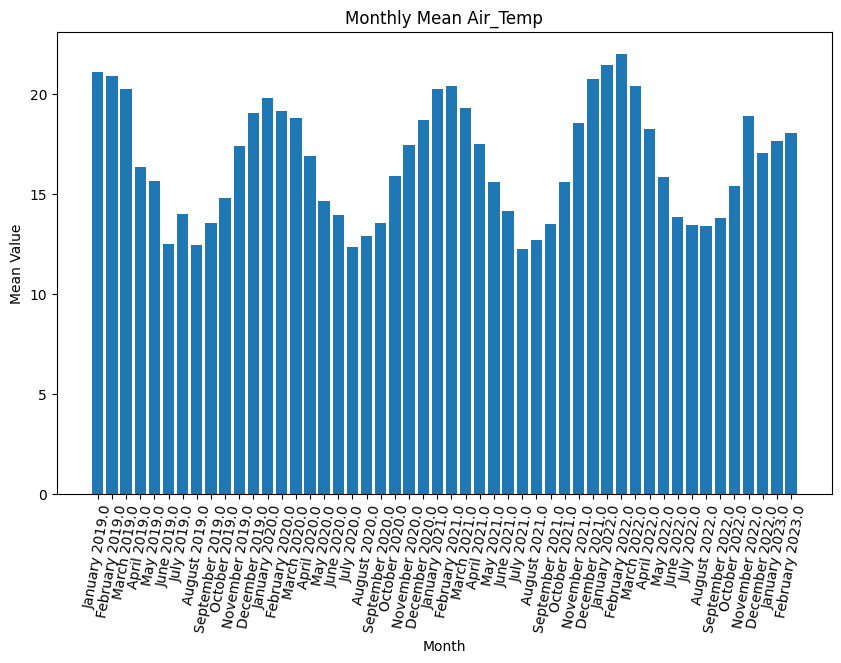

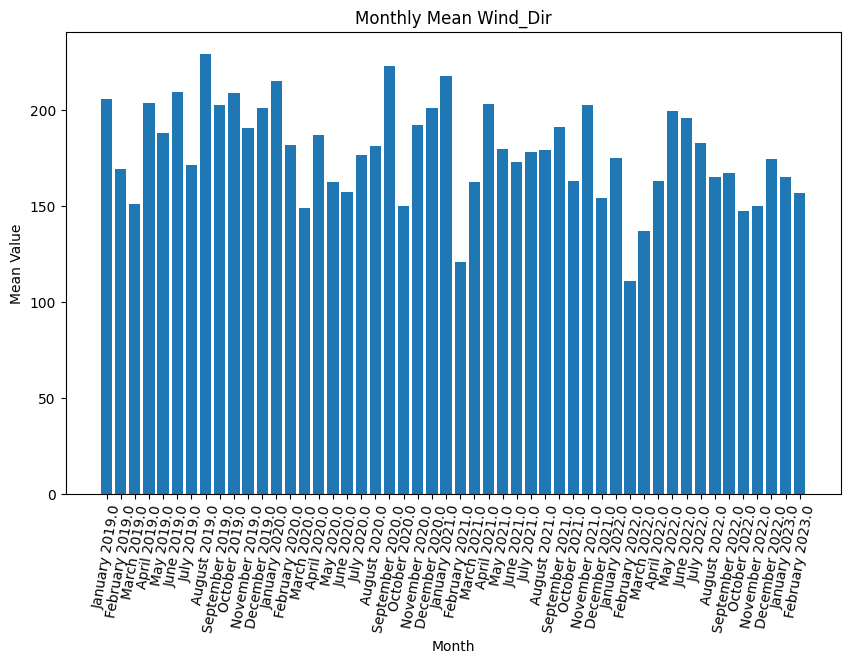

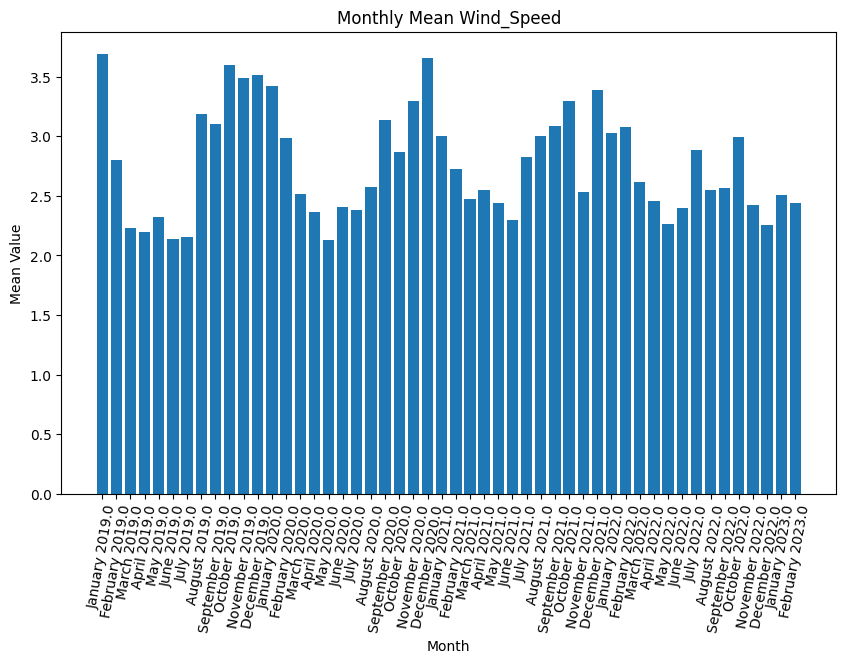

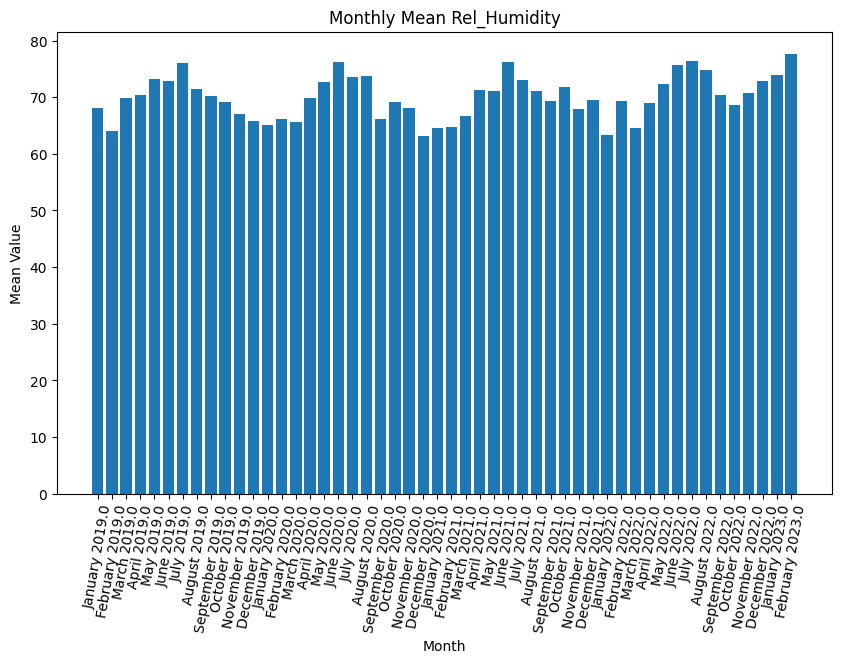

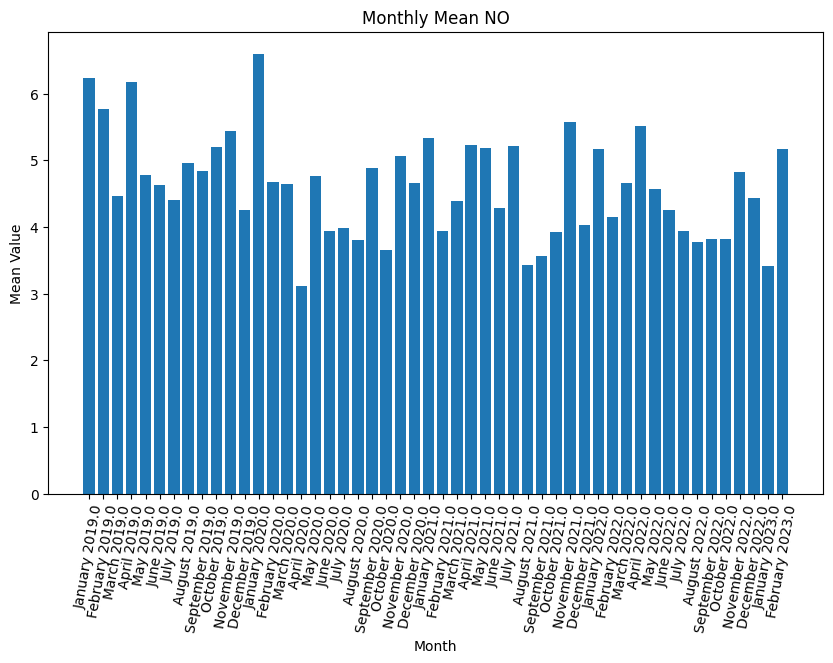

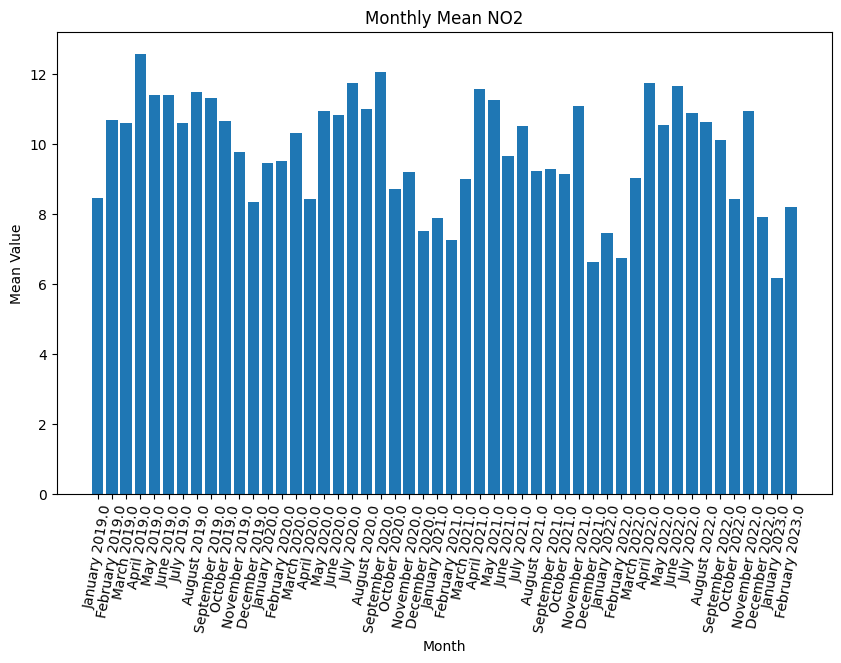

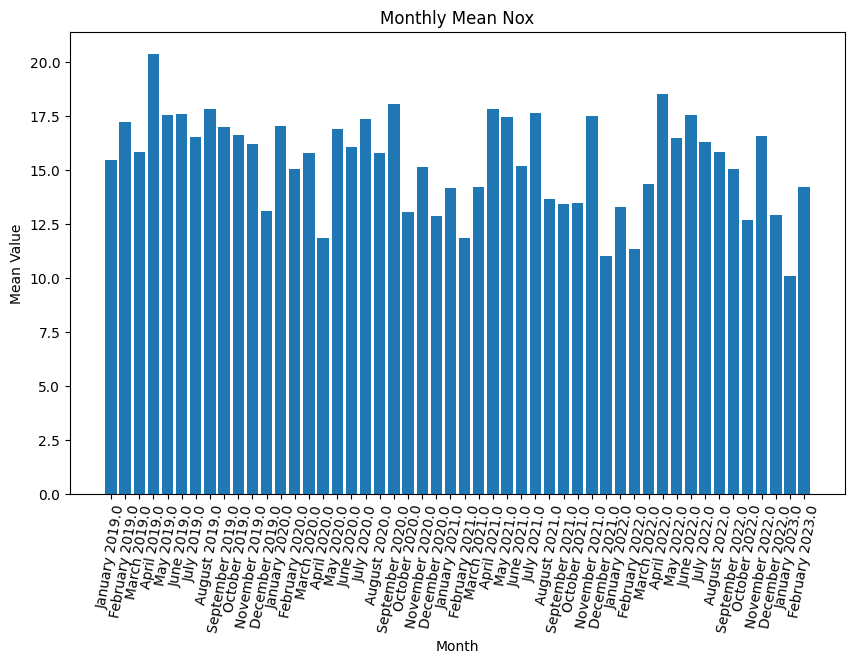

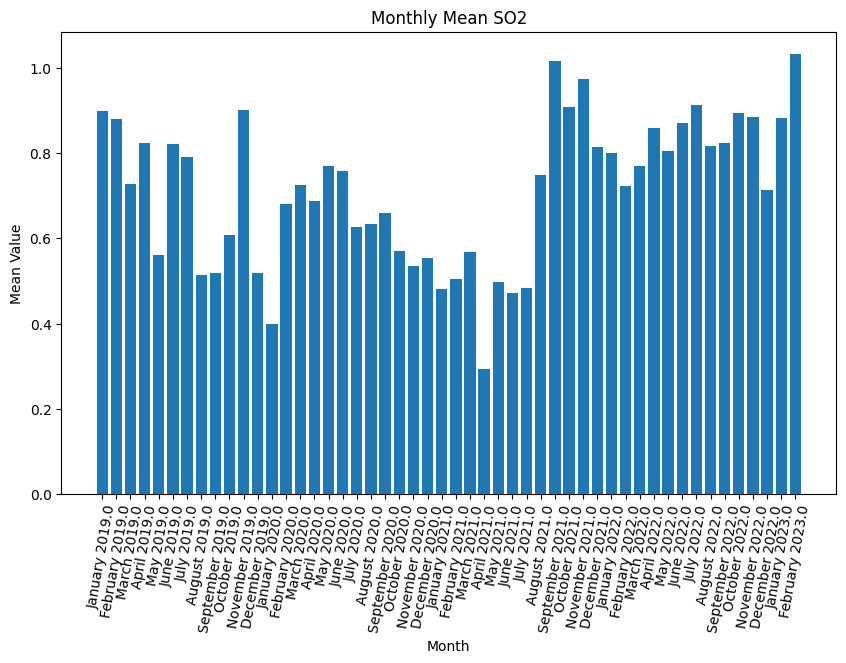

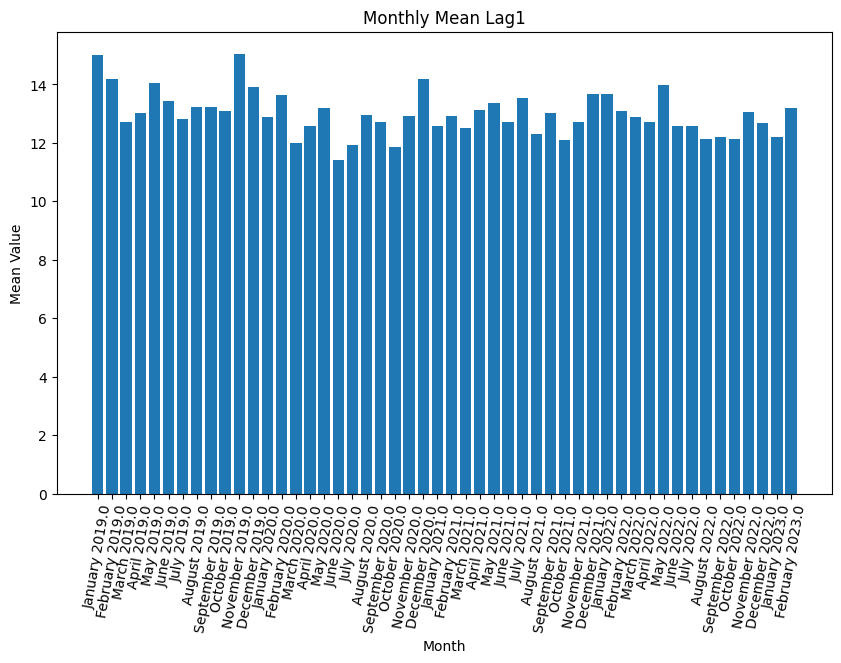

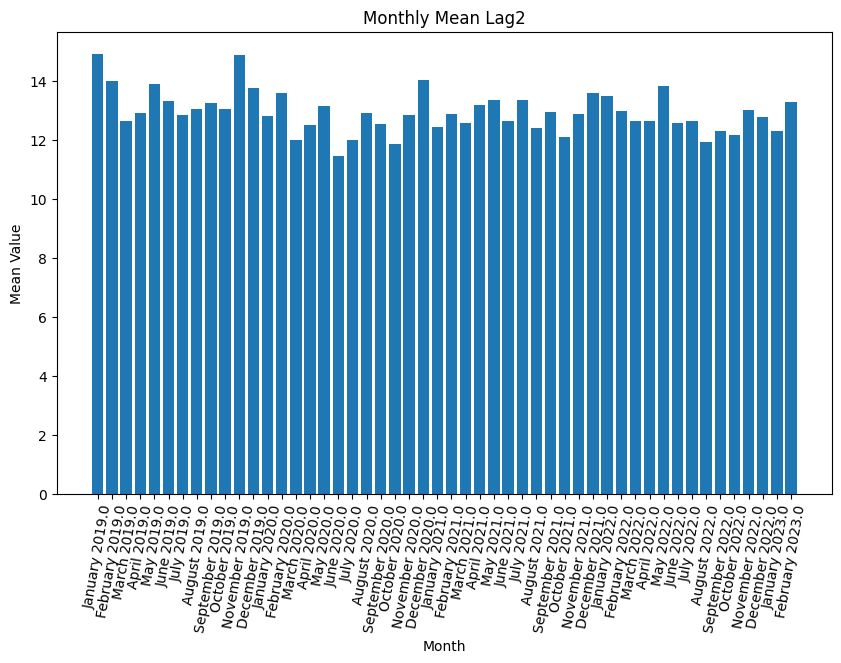

In [ ]:
# Convert the 'Start_of_Interval' column to datetime type
df2['Start_of_Interval'] = pd.to_datetime(df2['Start_of_Interval'], format='%d-%m-%Y %H:%M')

# Extract the month and year from the 'Start_of_Interval' column
df2['Month'] = df2['Start_of_Interval'].dt.month
df2['Year'] = df2['Start_of_Interval'].dt.year

# Iterate over each column and create separate bar plots
for column in df2.columns:
    if column not in ['Start_of_Interval', 'End_of_Interval','Month', 'Year']:
        # Group the data by year and month and calculate the mean for the current column
        df_monthly_mean = df2.groupby(['Year', 'Month'])[column].mean()

        # Create the x-axis labels using month and year
        x_labels = [f"{calendar.month_name[int(month)]} {year}" for year, month in df_monthly_mean.index]

        # Plot the bar chart for the current column
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(df_monthly_mean)), df_monthly_mean)
        plt.xlabel('Month')
        plt.ylabel('Mean Value')
        plt.title(f'Monthly Mean {column}')
        plt.xticks(range(len(df_monthly_mean)), x_labels, rotation=80)
        plt.show()


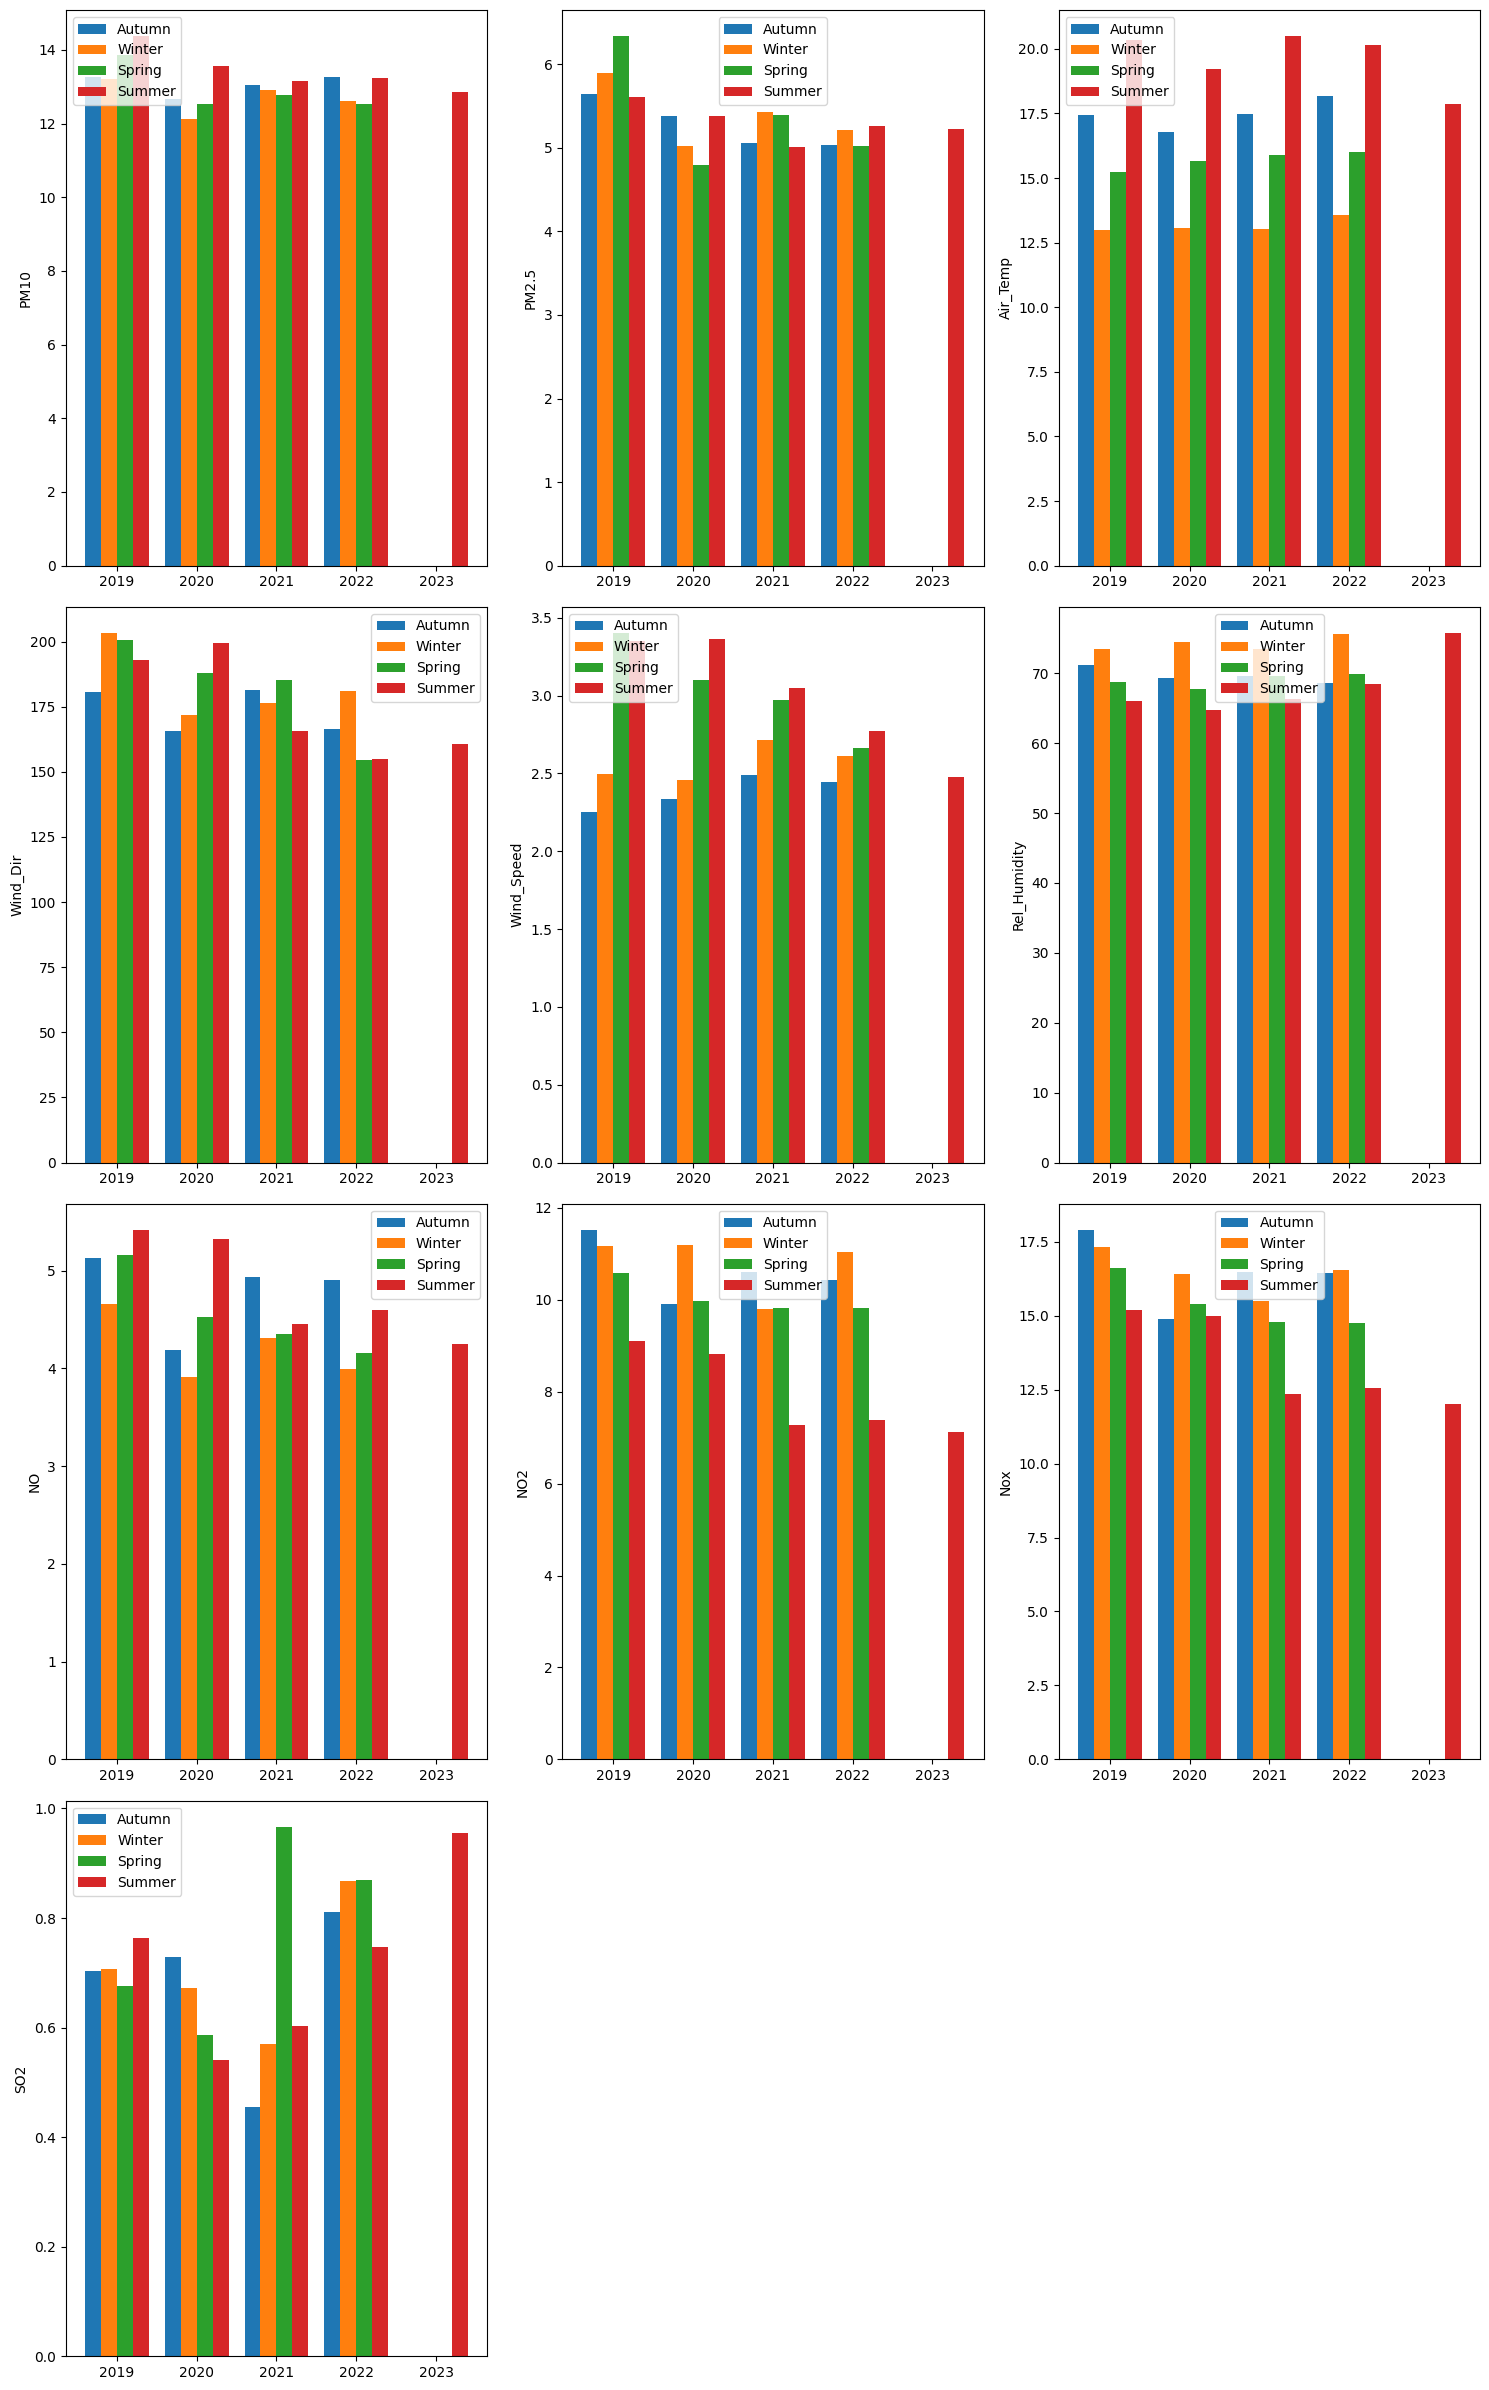

In [ ]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the seasons and corresponding months
seasons = {
    'Autumn': [3, 4, 5],
    'Winter': [6, 7, 8],
    'Spring': [9, 10, 11],
    'Summer': [12, 1, 2]
}

# Determine the number of rows and columns for the subplots
num_features = len(columns_to_visualize)
num_rows = (num_features + 2) // 3  # Add 2 to account for rounding up
num_cols = min(3, num_features)

# Create subplots with grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6 * num_rows))

# Flatten the subplots array to easily iterate over them
axs = axs.flatten()

# Iterate over each feature
for i, feature in enumerate(columns_to_visualize):
    # Initialize an array to store the mean values for each year and season
    seasonal_means = []

    # Iterate over each year
    for year in range(2019, 2024):
        # Initialize an array to store the mean values for each season in the current year
        season_means = []

        # Iterate over each season
        for season, months in seasons.items():
            # Filter the data for the current year and season
            mask = (df2['Year'] == year) & (df2['Month'].isin(months))
            seasonal_data = df2.loc[mask, feature]

            # Calculate the mean value for the season and year and append it to the array
            seasonal_mean = seasonal_data.mean()
            season_means.append(seasonal_mean)

        # Append the mean values for the current year to the overall array
        seasonal_means.extend(season_means)

    # Reshape the seasonal_means array to group the seasons together for each year
    seasonal_means = np.array(seasonal_means).reshape(len(range(2019, 2024)), -1)

    # Plot the grouped bar chart for all years and seasons
    x = np.arange(len(range(2019, 2024)))
    width = 0.2
    for j, season_means in enumerate(seasonal_means.T):
        axs[i].bar(x + (j - (len(seasonal_means.T) - 1) / 2) * width, season_means, width=width, label=list(seasons.keys())[j])

    # Set the x-axis tick positions and labels
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(range(2019, 2024))

    # Set the y-axis label
    axs[i].set_ylabel(feature)

    # Add a legend
    axs[i].legend()

# Hide any unused subplots
for j in range(num_features, num_rows * num_cols):
    fig.delaxes(axs[j])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


<BarContainer object of 36482 artists>

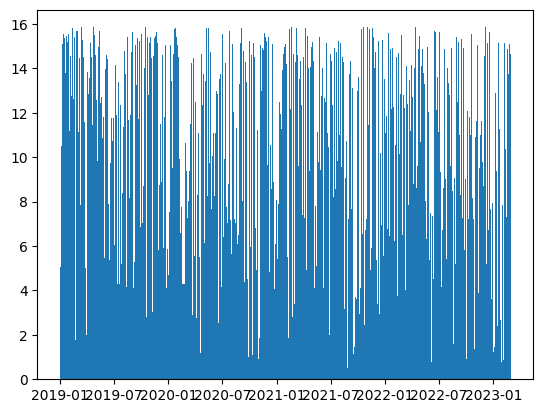

In [ ]:
plt.bar(df2['Start_of_Interval'],df2['NO'])

In [ ]:
print(df2.corr())

                  PM10     PM2.5  Air_Temp  Wind_Dir  Wind_Speed  \
PM10          1.000000  0.273237  0.089515  0.072514    0.170930   
PM2.5         0.273237  1.000000 -0.053141  0.088244    0.037488   
Air_Temp      0.089515 -0.053141  1.000000 -0.186825    0.315600   
Wind_Dir      0.072514  0.088244 -0.186825  1.000000   -0.041255   
Wind_Speed    0.170930  0.037488  0.315600 -0.041255    1.000000   
Rel_Humidity -0.172178 -0.023783 -0.365859 -0.099746   -0.392803   
NO            0.149653  0.117740  0.012011  0.305217    0.110027   
NO2          -0.002696  0.081058 -0.220005  0.338710   -0.220780   
Nox           0.063058  0.110067 -0.161606  0.342354   -0.124535   
SO2           0.091328  0.089881 -0.090773  0.082394   -0.099503   
Lag1          0.651164  0.252370  0.088149  0.075300    0.167051   
Lag2          0.433780  0.216942  0.077316  0.073065    0.144095   
Month        -0.002530  0.034560 -0.303770  0.045264    0.080899   
Year         -0.053632 -0.113201  0.075921 -0.12

<ipython-input-17-f754de695cf0>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

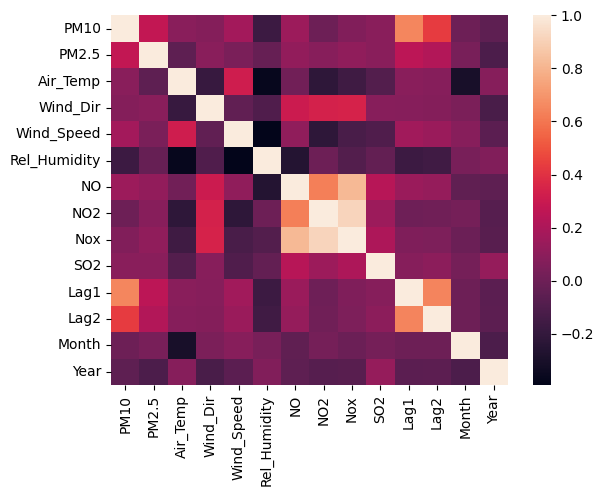

In [ ]:
warnings.filterwarnings("ignore")  # Ignore warnings

df2.corr()
sns.heatmap(df2.corr())

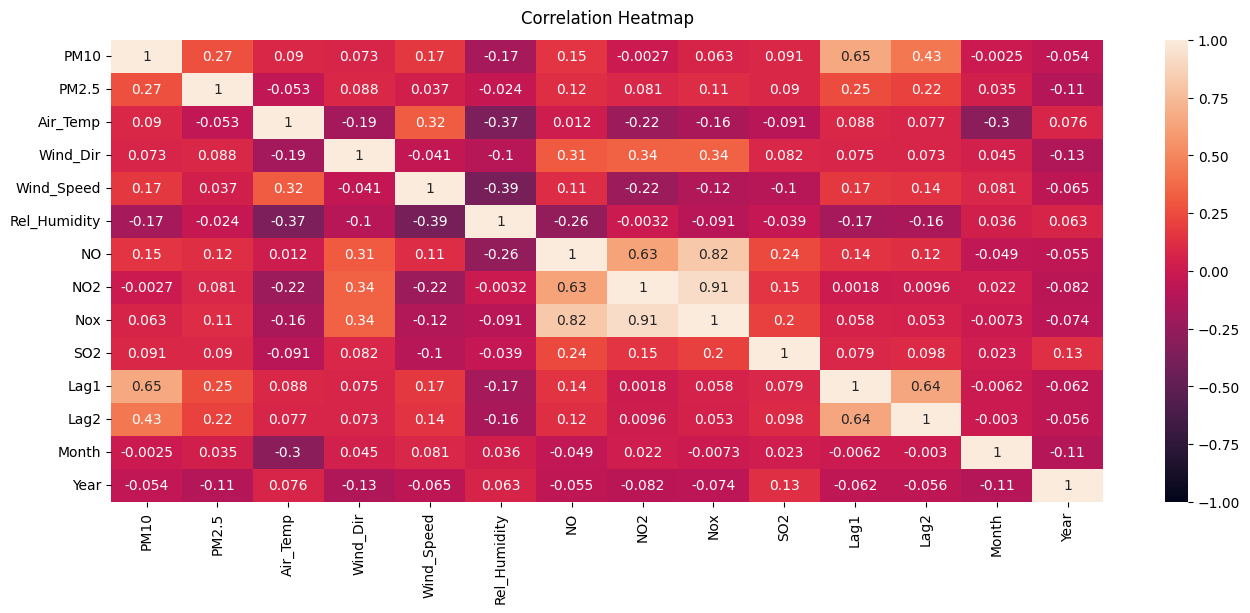

In [ ]:
warnings.filterwarnings("ignore")  # Ignore warnings

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df2 .corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
desc= df[['PM10','Air_Temp', 'Wind_Dir', 'Wind_Speed', 'Rel_Humidity', 'NO', 'NO2', 'SO2',"Lag1","Lag2"]]

Linear Regression



=========================================MODEL TRAINING===========================================


                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     262.6
Date:                Fri, 16 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:30:04   Log-Likelihood:                -71109.
No. Observations:               25537   AIC:                         1.422e+05
Df Residuals:                   25529   BIC:                         1.423e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

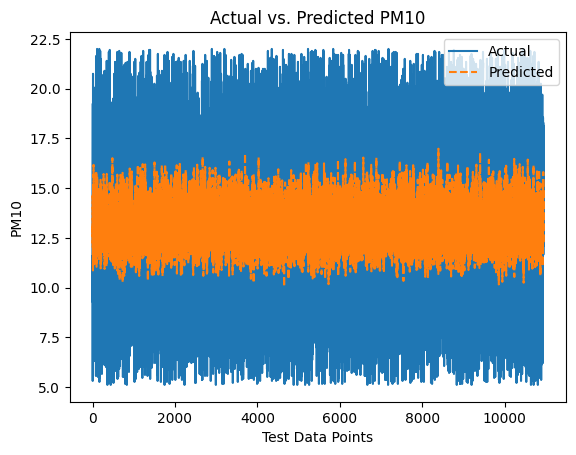

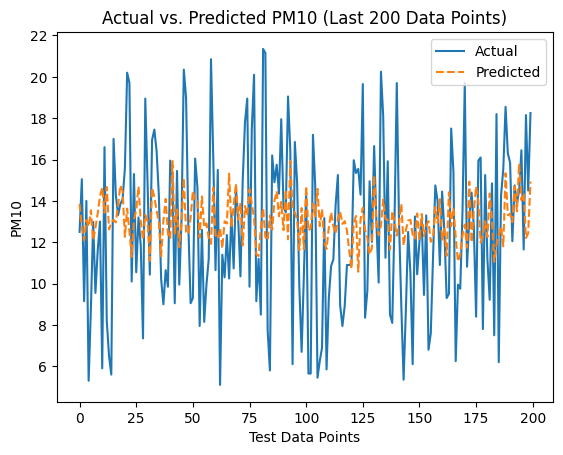


Linearity :


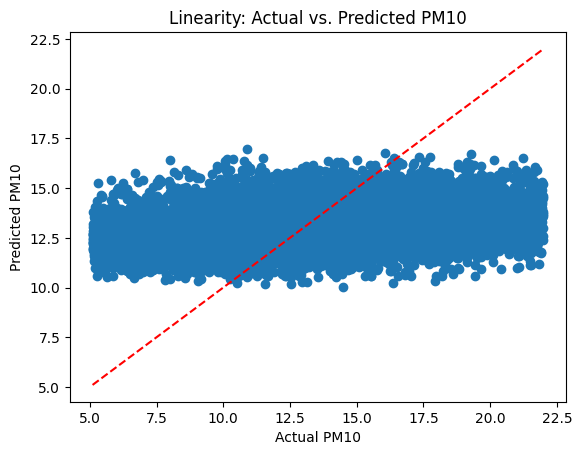


Normality :


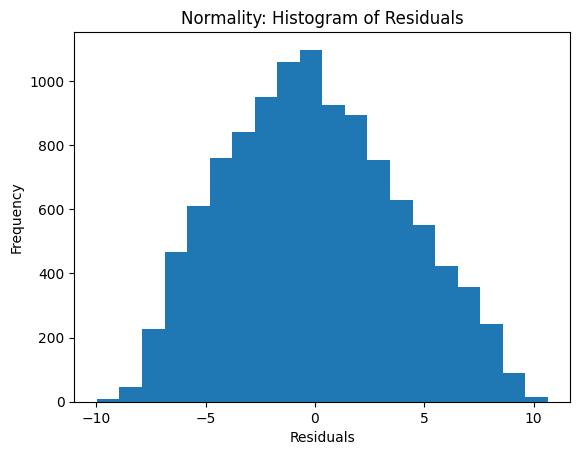

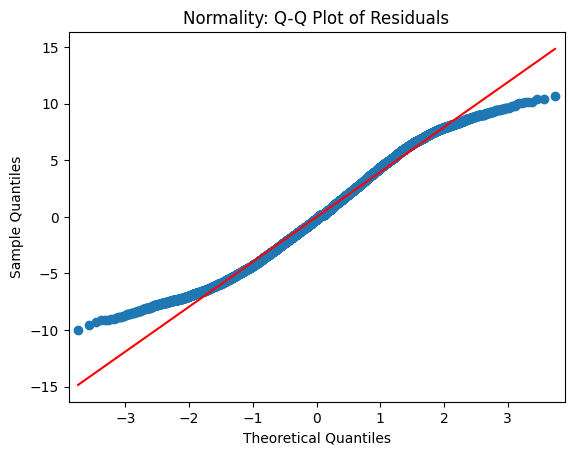

\Autocorrelation :


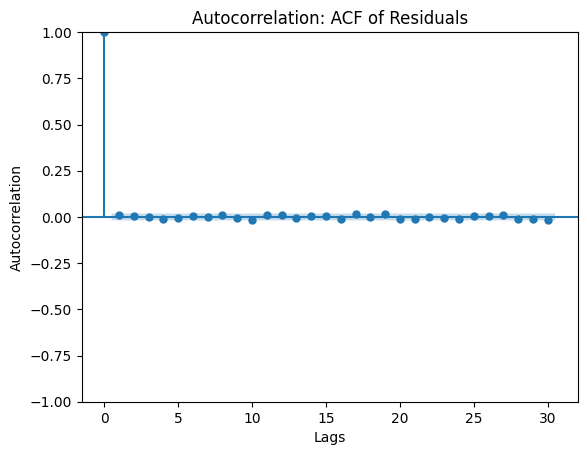

Ljung-Box test - p-values: lb_pvalue
\Homoscedasticity :


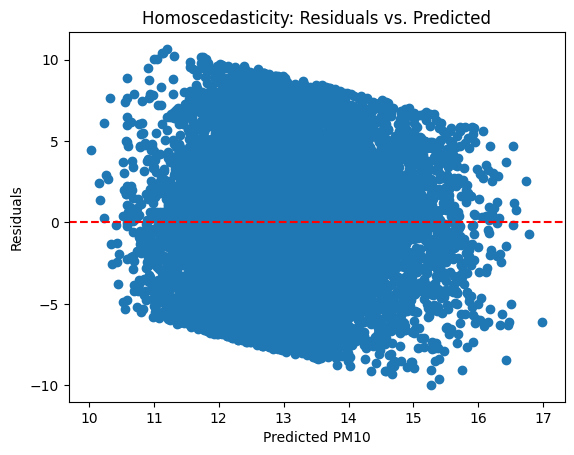

In [ ]:
data = df2.iloc[:, :-2]

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Separate the features and target variable for train and test data
X_train = train_data[['Air_Temp', 'Wind_Dir', 'Wind_Speed', 'Rel_Humidity', 'NO', 'NO2', 'SO2']]
y_train = train_data[['PM10']]

X_test = test_data[['Air_Temp', 'Wind_Dir', 'Wind_Speed', 'Rel_Humidity', 'NO', 'NO2', 'SO2']]
y_test = test_data[['PM10']]

# Fit the linear regression model using the train data
mod = smf.ols("PM10 ~ Air_Temp + Wind_Dir + Wind_Speed + Rel_Humidity + NO + NO2 + SO2", data=train_data)
mod_res = mod.fit()
print("\n\n=========================================MODEL TRAINING===========================================\n\n")

print(mod_res.summary())

print("\n\n=========================================MODEL EVALUATION===========================================")

# Predict the target variable for the test data
y_pred = mod_res.predict(test_data)

# Calculate performance metrics for linear regression model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)

print("\nLinear Regression Model Performance Metrics:")
print("RMSE:", lr_rmse)
print("MAE:", lr_mae)
print("R2:", lr_r2)
print("MSE:", lr_mse)

print("\n")
# Create a line plot of actual vs. predicted values
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred.values, label='Predicted', linestyle="--")
plt.xlabel('Test Data Points')
plt.ylabel('PM10')
plt.title('Actual vs. Predicted PM10')
plt.legend()
plt.show()

print("\n")
# Create a line plot of actual vs. predicted values for the last 200 data points
plt.plot(y_test.values[-200:], label='Actual')
plt.plot(y_pred.values[-200:], label='Predicted', linestyle="--")
plt.xlabel('Test Data Points')
plt.ylabel('PM10')
plt.title('Actual vs. Predicted PM10 (Last 200 Data Points)')
plt.legend()
plt.show()

y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['PM10'])

print("\nLinearity :")
# Plotting predicted values vs. residuals
plt.scatter(y_test, y_pred)
plt.xlabel('Actual PM10')
plt.ylabel('Predicted PM10')
plt.title('Linearity: Actual vs. Predicted PM10')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')  # Add a diagonal line
plt.show()


print("\nNormality :")
# Histogram of residuals
plt.hist(residuals['PM10'], bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Normality: Histogram of Residuals')
plt.show()

# Q-Q plot of residuals
sm.qqplot(residuals['PM10'], line='s')
plt.title('Normality: Q-Q Plot of Residuals')
plt.show()


print("\Autocorrelation :")
# Autocorrelation function (ACF) plot of residuals
sm.graphics.tsa.plot_acf(residuals, lags=30)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation: ACF of Residuals')
plt.show()
# Ljung-Box test for autocorrelation
lb_value, p_value = sm.stats.acorr_ljungbox(residuals, lags=10)
print('Ljung-Box test - p-values:', p_value)

print("\Homoscedasticity :")
# Plotting residuals vs. predicted values
plt.scatter(y_pred_df['PM10'], residuals['PM10'])
plt.xlabel('Predicted PM10')
plt.ylabel('Residuals')
plt.title('Homoscedasticity: Residuals vs. Predicted')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.show()



Train - Test Split for MLP

In [ ]:
X = df2[['Air_Temp', 'Wind_Dir', 'Wind_Speed', 'Rel_Humidity', 'NO', 'NO2', 'SO2',"Lag1","Lag2"]].values
y = df2[['PM10']].values

Single Layer MLP

MLPRegressor Model Performance Metrics:
RMSE: 3.0912576831269765
MAE: 2.4102823196998213
R2: 0.43160482087473295
MSE: 9.555874063491563


Best Learning Rate: 0.0001
Best MSE: 9.496784588148817




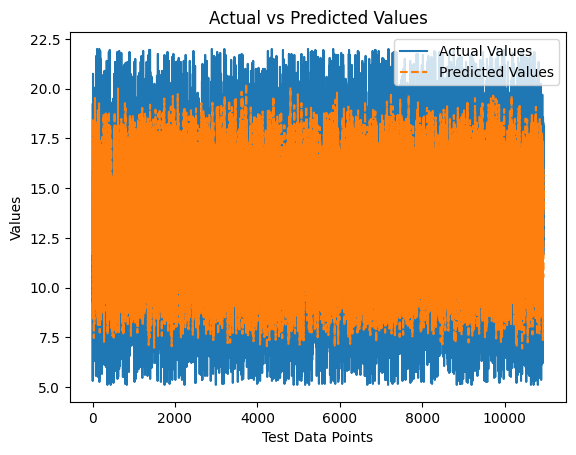

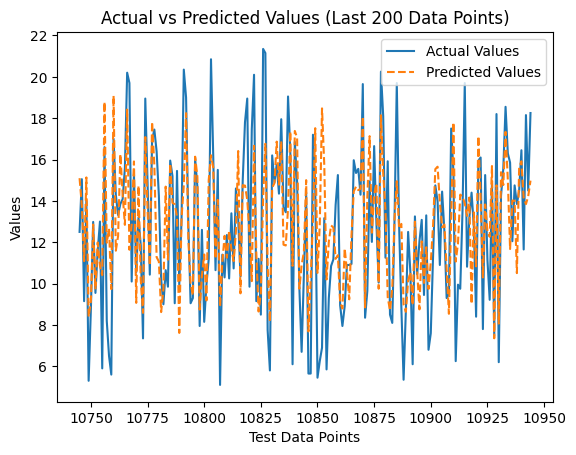

In [ ]:
warnings.filterwarnings("ignore")  # Ignore warnings

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0]  # Experiment with different learning rates

best_learning_rate = None
best_mse = float('inf')

# Iterate over different learning rates
for learning_rate in learning_rates:
    # Create MLPRegressor with a single hidden layer of 25 neurons
    mlp = MLPRegressor(hidden_layer_sizes=(25,), learning_rate_init=learning_rate, random_state=42)

    # Fit the model on the training data
    mlp.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = mlp.predict(X_test)

    # Calculate mean squared error (MSE) on the test data
    mse = mean_squared_error(y_test, y_pred)

    # Check if current learning rate gives better performance
    if mse < best_mse:
        best_mse = mse
        best_learning_rate = learning_rate

# Train the final model with the best learning rate
mlp = MLPRegressor(hidden_layer_sizes=(25,), learning_rate_init=best_learning_rate, activation='relu', solver='adam', max_iter=100, random_state=42)
mlp.fit(X_train, y_train)

# Make predictions on the test data
test_predictions = mlp.predict(X_test)

# Calculate performance metrics for MLPRegressor model
one_mlp_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
one_mlp_mae = mean_absolute_error(y_test, test_predictions)
one_mlp_r2 = r2_score(y_test, test_predictions)
one_mse_mlp = mean_squared_error(y_test, test_predictions)

# Print the performance metrics
print("MLPRegressor Model Performance Metrics:")
print("RMSE:", one_mlp_rmse)
print("MAE:", one_mlp_mae)
print("R2:", one_mlp_r2)
print("MSE:", one_mse_mlp)


# Print the best learning rate and corresponding MSE
print("\n\nBest Learning Rate:", best_learning_rate)
print("Best MSE:", best_mse)


# Plot actual vs predicted values
# Create an array of indices for x-axis
x = np.arange(len(y_test))

print("\n")
# Plot actual and predicted values as lines
plt.plot(x, y_test, label='Actual Values')
plt.plot(x, test_predictions, label='Predicted Values', linestyle="--")
plt.xlabel("Test Data Points")
plt.ylabel("Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

print("\n")
# Plot actual and predicted values for the last 200 data points
plt.plot(x[-200:], y_test[-200:], label='Actual Values')
plt.plot(x[-200:], test_predictions[-200:], label='Predicted Values', linestyle="--")
plt.xlabel("Test Data Points")
plt.ylabel("Values")
plt.title("Actual vs Predicted Values (Last 200 Data Points)")
plt.legend()
plt.show()


Two Layer MLP


MLP Model Performance Metrics:
RMSE: 3.0762154716286054
MAE: 2.367515241049881
R2: 0.4351980689607421
MSE: 9.463101627887204

Best Learning Rate: 0.01
Best MSE: 9.271019950258031

Split of the number of neurons across each of the two layers that gives the highest accuracy :  3 22




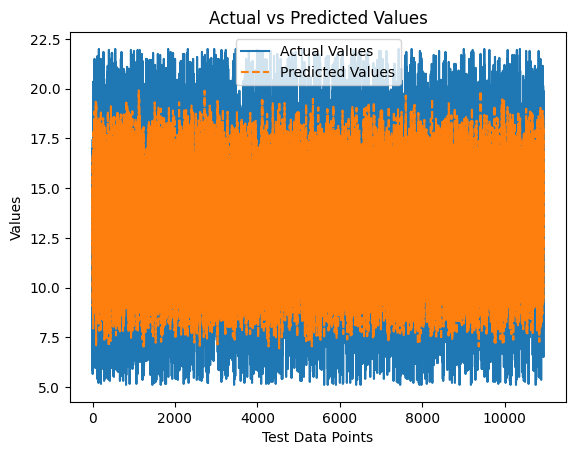

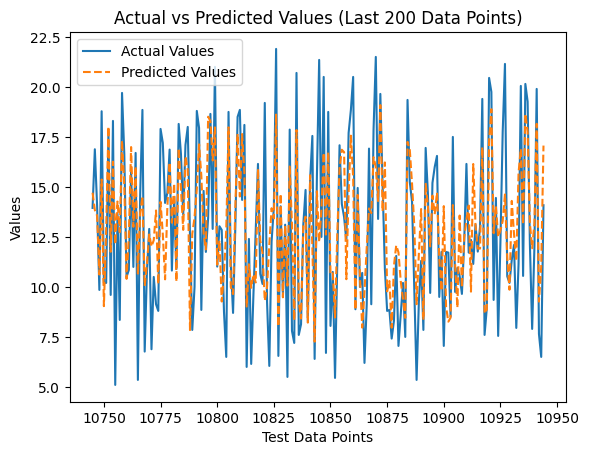

In [ ]:
warnings.filterwarnings("ignore")  # Ignore warnings

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0]  # Experiment with different learning rates
hidden_layer_neurons = 25  # Number of input features

best_learning_rate = None
best_mse = float('inf')
best_hidden_layer_split = None

# Iterate over different learning rates and hidden layer splits
for learning_rate in learning_rates:
    for split in range(1, hidden_layer_neurons):
        # Calculate the number of neurons in each hidden layer
        neurons_layer1 = hidden_layer_neurons - split
        neurons_layer2 = split

        # Create MLPRegressor with two hidden layers
        mlp = MLPRegressor(hidden_layer_sizes=(neurons_layer1, neurons_layer2), learning_rate_init=learning_rate)

        # Fit the model on the training data
        mlp.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = mlp.predict(X_test)

        # Calculate mean squared error (MSE) on the test data
        mse = mean_squared_error(y_test, y_pred)

        # Check if current learning rate and hidden layer split gives better performance
        if mse < best_mse:
            best_mse = mse
            best_learning_rate = learning_rate
            best_hidden_layer_split = split

# Calculate the number of neurons in each hidden layer for the best split
best_neurons_layer1 = hidden_layer_neurons - best_hidden_layer_split
best_neurons_layer2 = best_hidden_layer_split

# Train the final model with the best learning rate and hidden layer split
mlp = MLPRegressor(hidden_layer_sizes=(best_neurons_layer1, best_neurons_layer2), learning_rate_init=best_learning_rate, activation='relu', solver='adam', max_iter=100)
mlp.fit(X_train, y_train)

# Make predictions on the test data
test_predictions = mlp.predict(X_test)

# Plot actual vs predicted values
# Create an array of indices for x-axis
x = np.arange(len(y_test))

print("\n===============================================================================")
y_test_pred_mlp = mlp.predict(X_test)

# Calculate performance metrics for MLP model
two_rmse_mlp = np.sqrt(mean_squared_error(y_test, y_test_pred_mlp))
two_mae_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
two_r2_mlp = r2_score(y_test, y_test_pred_mlp)
two_mse_mlp = mean_squared_error(y_test, y_test_pred_mlp)

print("MLP Model Performance Metrics:")
print("RMSE:", two_rmse_mlp)
print("MAE:", two_mae_mlp)
print("R2:", two_r2_mlp)
print("MSE:", two_mse_mlp)

# Print the best learning rate and corresponding MSE
print("\nBest Learning Rate:", best_learning_rate)
print("Best MSE:", best_mse)

print("\nSplit of the number of neurons across each of the two layers that gives the highest accuracy : ", best_neurons_layer1, best_neurons_layer2)

print("\n")
# Plot actual and predicted values as lines
plt.plot(x, y_test, label='Actual Values')
plt.plot(x, test_predictions, label='Predicted Values', linestyle="--")
plt.xlabel("Test Data Points")
plt.ylabel("Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

print("\n")
plt.plot(x[-200:], y_test[-200:], label='Actual Values')
plt.plot(x[-200:], test_predictions[-200:], label='Predicted Values', linestyle="--")
plt.xlabel("Test Data Points")
plt.ylabel("Values")
plt.title("Actual vs Predicted Values (Last 200 Data Points)")
plt.legend()
plt.show()

2. LSTM


Epoch Runtimes:
Epoch 1 - Execution Time: 39.73940396308899 seconds
Epoch 2 - Execution Time: 37.09808564186096 seconds
Epoch 3 - Execution Time: 41.053252935409546 seconds
Epoch 4 - Execution Time: 41.01289439201355 seconds
Epoch 5 - Execution Time: 41.01210021972656 seconds
Epoch 6 - Execution Time: 41.03565692901611 seconds
Epoch 7 - Execution Time: 41.0192666053772 seconds
Epoch 8 - Execution Time: 41.00816559791565 seconds
Epoch 9 - Execution Time: 41.011130571365356 seconds
Epoch 10 - Execution Time: 41.039337396621704 seconds
Epoch 11 - Execution Time: 41.014408349990845 seconds
Epoch 12 - Execution Time: 41.05085062980652 seconds
Epoch 13 - Execution Time: 41.0457603931427 seconds
Epoch 14 - Execution Time: 43.410892963409424 seconds
Epoch 15 - Execution Time: 39.35758590698242 seconds
Epoch 16 - Execution Time: 36.060590744018555 seconds
Epoch 17 - Execution Time: 41.00668478012085 seconds
Epoch 18 - Execution Time: 41.03916382789612 seconds
Epoch 19 - Execution Time: 41.0221

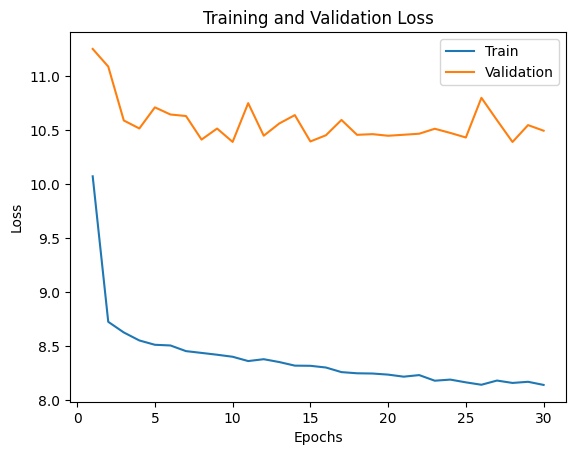

342/342 [==============================] - 1s 2ms/step

Metrics:
MSE: 10.494405728737222
RMSE: 3.2395070193992823
MAE: 2.535127349051189
R2: 0.39298488980709234

Training Loss Summary Statistics:
Mean: 8.386359628041586
Standard Deviation: 0.3468489043729992
Minimum: 8.143919944763184
Maximum: 10.07261848449707

Validation Loss Summary Statistics:
Mean: 10.570329825083414
Standard Deviation: 0.19199437208447367
Minimum: 10.39008617401123
Maximum: 11.25046157836914

Best Epoch: 28




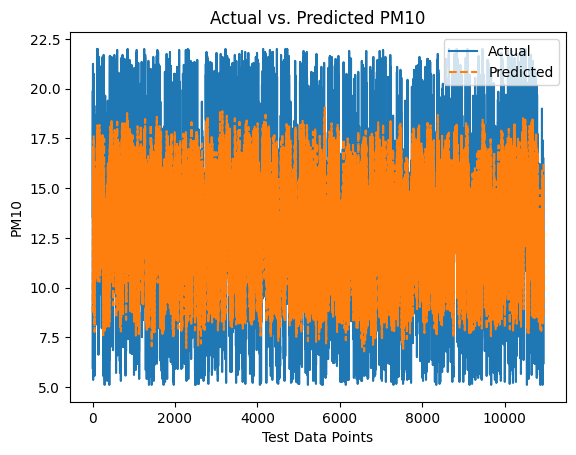

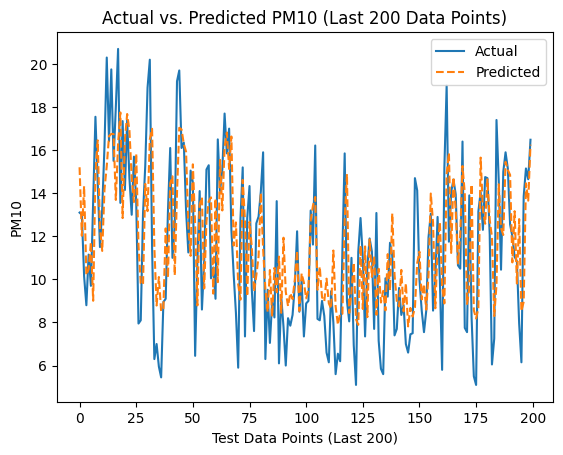

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

num_features = X.shape[1]
timesteps = 10

if X.shape[0] < timesteps:
    raise ValueError("Not enough data to create sequences")

X_reshaped = []
y_reshaped = []
for i in range(len(X) - timesteps + 1):
    X_reshaped.append(X[i:i + timesteps])
    y_reshaped.append(y[i + timesteps - 1])  # Adjusted indexing for y

X_reshaped = np.array(X_reshaped)
y_reshaped = np.array(y_reshaped)

train_data, test_data, train_labels, test_labels = train_test_split(
    X_reshaped, y_reshaped, test_size=0.3, random_state=42, shuffle=False
)

model = Sequential()
model.add(LSTM(25, input_shape=(timesteps, num_features), activation='tanh'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

epochs = 30
batch_size = 4
train_loss = []
val_loss = []

epoch_times = []
print("\nEpoch Runtimes:")
for epoch in range(epochs):
    start_time = time.time()
    history = model.fit(
        train_data,
        train_labels,
        epochs=1,
        batch_size=batch_size,
        validation_data=(test_data, test_labels),
        verbose=0
    )
    end_time = time.time()
    epoch_time = end_time - start_time
    epoch_times.append(epoch_time)
    print(f"Epoch {epoch+1} - Execution Time: {epoch_time} seconds")

    train_loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])

print("\n")
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_loss, label='Train')
plt.plot(epochs_range, val_loss, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


train_loss_stats = {
    'Mean': np.mean(train_loss),
    'Standard Deviation': np.std(train_loss),
    'Minimum': np.min(train_loss),
    'Maximum': np.max(train_loss)
}

val_loss_stats = {
    'Mean': np.mean(val_loss),
    'Standard Deviation': np.std(val_loss),
    'Minimum': np.min(val_loss),
    'Maximum': np.max(val_loss)
}

# Reshape test_data before prediction
test_data_reshaped = np.reshape(test_data, (test_data.shape[0], timesteps, num_features))
test_predictions = model.predict(test_data_reshaped)

mse = mean_squared_error(test_labels, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_labels, test_predictions)
r2 = r2_score(test_labels, test_predictions)

print("\nMetrics:")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

print("\nTraining Loss Summary Statistics:")
for key, value in train_loss_stats.items():
    print(key + ':', value)

print("\nValidation Loss Summary Statistics:")
for key, value in val_loss_stats.items():
    print(key + ':', value)

epoch_runtimes = np.diff(epoch_times)
epoch_runtimes = np.insert(epoch_runtimes, 0, 0)

best_epoch = np.argmin(val_loss) + 1
print("\nBest Epoch:", best_epoch)


print("\n")
# Plot the actual vs. predicted values
plt.plot(test_labels, label='Actual')
plt.plot(test_predictions, label='Predicted', linestyle="--")
plt.xlabel('Test Data Points')
plt.ylabel('PM10')
plt.title('Actual vs. Predicted PM10')
plt.legend()
plt.show()

print("\n")
# Plot the last 200 actual vs. predicted test data points
last_200_test_labels = test_labels[-200:]
last_200_test_predictions = test_predictions[-200:]
x = np.arange(len(last_200_test_labels))

plt.plot(x, last_200_test_labels, label='Actual')
plt.plot(x, last_200_test_predictions, label='Predicted', linestyle="--")
plt.xlabel('Test Data Points (Last 200)')
plt.ylabel('PM10')
plt.title('Actual vs. Predicted PM10 (Last 200 Data Points)')
plt.legend()
plt.show()


Execution Times:
Batch Size 4: 27 seconds
Batch Size 8: 27 seconds
Batch Size 16: 27 seconds
Batch Size 32: 27 seconds
Batch Size 64: 27 seconds
Batch Size 90: 27 seconds
Batch Size 128: 27 seconds
Batch Size 160: 27 seconds
Batch Size 200: 27 seconds
Batch Size 250: 27 seconds
Batch Size 300: 27 seconds
342/342 [==============================] - 2s 3ms/step


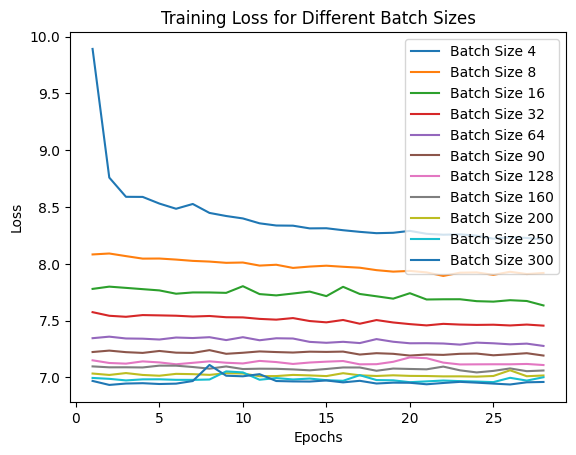


Metrics:
MSE: 10.977163913432141
RMSE: 3.3131803321630624
MAE: 2.5915349727794665
R2: 0.3650612969659399

Cost Function Summary Statistics:
Batch Size 4:
Mean: 8.415330137525286
Standard Deviation: 0.3140608813809735
Minimum: 8.213284492492676
Maximum: 9.891216278076172

Batch Size 8:
Mean: 7.979232379368374
Standard Deviation: 0.05612964123364669
Minimum: 7.893540382385254
Maximum: 8.09091567993164

Batch Size 16:
Mean: 7.729582224573408
Standard Deviation: 0.04455160133393914
Minimum: 7.633872032165527
Maximum: 7.803248882293701

Batch Size 32:
Mean: 7.50337108543941
Standard Deviation: 0.034740447975385905
Minimum: 7.456069469451904
Maximum: 7.5747199058532715

Batch Size 64:
Mean: 7.322377460343497
Standard Deviation: 0.02336863331819761
Minimum: 7.277585983276367
Maximum: 7.359174728393555

Batch Size 90:
Mean: 7.215225917952401
Standard Deviation: 0.012766280181606995
Minimum: 7.192820072174072
Maximum: 7.240419864654541

Batch Size 128:
Mean: 7.130994779723031
Standard Deviatio

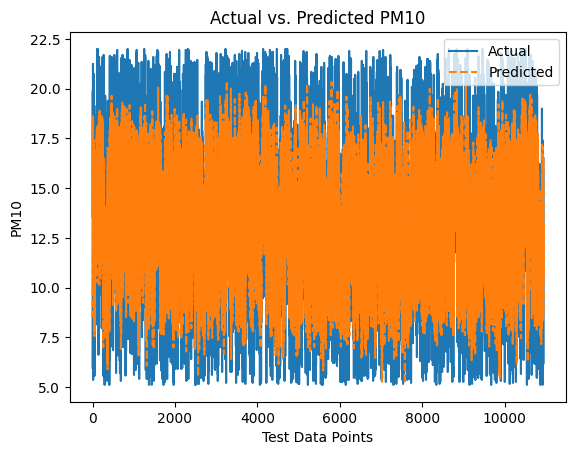

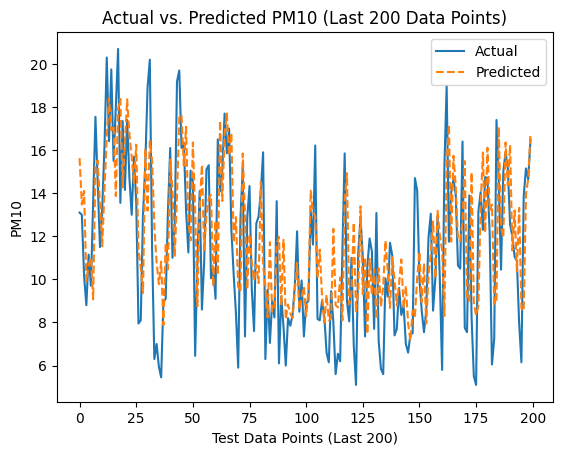

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(25, input_shape=(timesteps, num_features), activation='tanh'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Set the number of epochs and batch sizes to try
epochs = best_epoch
batch_sizes = [4, 8, 16, 32, 64, 90, 128, 160, 200, 250, 300]

# Initialize lists to store the cost function values and runtimes
cost_functions = []
runtimes = []

# Perform training runs for each batch size
for batch_size in batch_sizes:
    train_loss = []

    # Train the LSTM model
    history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_labels), verbose=0)

    # Retrieve the training loss values from the history
    train_loss = history.history['loss']

    # Calculate the run time for the training run
    runtime = sum(np.diff(history.epoch))

    # Store the cost function values and runtimes
    cost_functions.append(train_loss)
    runtimes.append(runtime)

# Convert the cost function values and runtimes to NumPy arrays
cost_functions = np.array(cost_functions)
runtimes = np.array(runtimes)

# Print the execution times
print("\nExecution Times:")
for i, batch_size in enumerate(batch_sizes):
    print(f"Batch Size {batch_size}: {runtimes[i]} seconds")

# Calculate the summary statistics of the cost function
cost_function_stats = {
    'Mean': np.mean(cost_functions, axis=1),
    'Standard Deviation': np.std(cost_functions, axis=1),
    'Minimum': np.min(cost_functions, axis=1),
    'Maximum': np.max(cost_functions, axis=1)
}

# Calculate the summary statistics of the runtimes
runtime_stats = {
    'Mean': np.mean(runtimes),
    'Standard Deviation': np.std(runtimes),
    'Minimum': np.min(runtimes),
    'Maximum': np.max(runtimes)
}

test_predictions = model.predict(test_data)

# Plot the cost function for each batch size
epochs_range = range(1, epochs+1)
for i, batch_size in enumerate(batch_sizes):
    plt.plot(epochs_range, cost_functions[i], label=f"Batch Size {batch_size}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Different Batch Sizes')
plt.legend()
plt.show()

# Calculate the metrics
mse = mean_squared_error(test_labels, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_labels, test_predictions)
r2 = r2_score(test_labels, test_predictions)

# Print the metrics
print("\nMetrics:")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

# Print the summary statistics of the cost function
print("\nCost Function Summary Statistics:")
for i, batch_size in enumerate(batch_sizes):
    print(f"Batch Size {batch_size}:")
    for key, value in cost_function_stats.items():
        print(f"{key}: {value[i]}")
    print()

# Print the summary statistics of the runtimes
print("Runtime Summary Statistics:")
for key, value in runtime_stats.items():
    print(f"{key}: {value}")

# Choose the best batch size based on the cost function
best_batch_size = batch_sizes[np.argmin(np.mean(cost_functions, axis=1))]
print("\nBest Batch Size:", best_batch_size)

print("\n")
# Plot the actual vs. predicted values
plt.plot(test_labels, label='Actual')
plt.plot(test_predictions, label='Predicted', linestyle="--")
plt.xlabel('Test Data Points')
plt.ylabel('PM10')
plt.title('Actual vs. Predicted PM10')
plt.legend()
plt.show()

print("\n")
# Plot the last 200 actual vs. predicted test data points
last_200_test_labels = test_labels[-200:]
last_200_test_predictions = test_predictions[-200:]
x = np.arange(len(last_200_test_labels))

plt.plot(x, last_200_test_labels, label='Actual')
plt.plot(x, last_200_test_predictions, label='Predicted', linestyle="--")
plt.xlabel('Test Data Points (Last 200)')
plt.ylabel('PM10')
plt.title('Actual vs. Predicted PM10 (Last 200 Data Points)')
plt.legend()
plt.show()


Execution Times:
Batch Size 10: 42.96784019470215 seconds
Batch Size 25: 32.436527729034424 seconds
Batch Size 50: 58.348551750183105 seconds
Batch Size 75: 82.35769724845886 seconds
Batch Size 100: 106.47578239440918 seconds
Batch Size 125: 133.10644483566284 seconds
Batch Size 150: 162.96933913230896 seconds
Batch Size 175: 203.93149089813232 seconds
Batch Size 200: 264.49300503730774 seconds
Batch Size 225: 324.20796275138855 seconds
Batch Size 250: 339.0349566936493 seconds
Batch Size 275: 443.9301314353943 seconds
Batch Size 300: 503.9822573661804 seconds

Cost Function Summary Statistics:
Mean: 8.456754244290865
Standard Deviation: 0.10752927506758941
Minimum: 8.323253631591797
Maximum: 8.703187942504883

Runtime Summary Statistics (seconds):
Mean: 207.55707595898554
Standard Deviation: 149.7002385931745
Minimum: 32.436527729034424
Maximum: 503.9822573661804




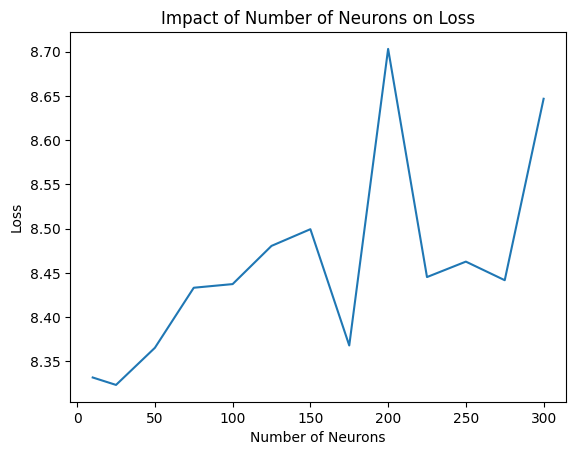


Optimal Number of Neurons: 25
342/342 [==============================] - 1s 2ms/step

MSE: 10.617290085273023
RMSE: 3.258418341047236
R2: 0.38587703985811384
MAE: 2.5494649704410874




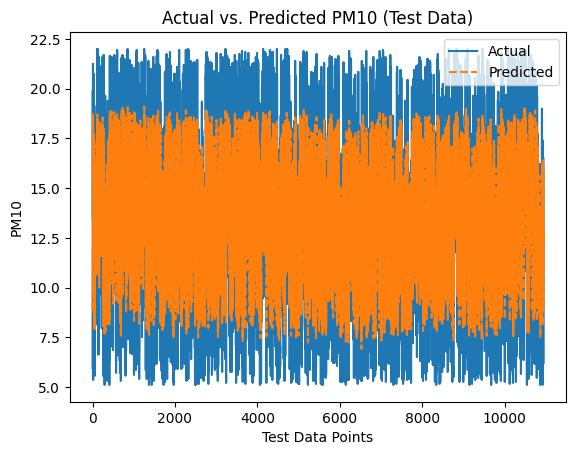

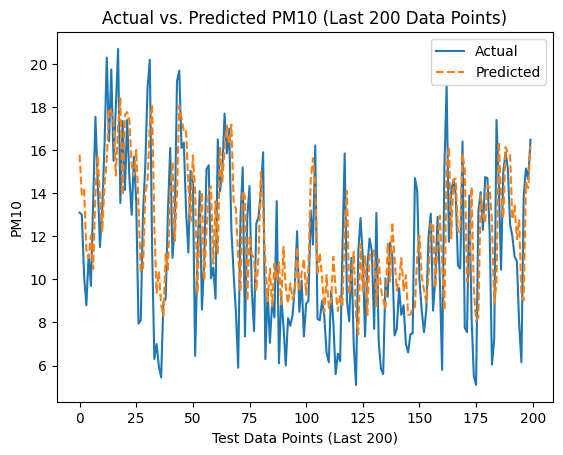

In [ ]:
# Define the number of neurons to investigate
neurons = [10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]

# Define the constant epoch and batch size
epochs = best_epoch
batch_size = best_batch_size

# Define empty lists to store the results
loss_values = []
runtime_values = []

# Iterate over different numbers of neurons
for num_neurons in neurons:
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(num_neurons, input_shape=(timesteps, num_features), activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

    # Train the LSTM model
    start_time = time.time()
    history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_labels), verbose=0)
    end_time = time.time()

    # Record the loss and runtime
    loss_values.append(history.history['loss'][-1])
    runtime_values.append(end_time - start_time)

# Convert the cost function values and runtimes to NumPy arrays
loss_values = np.array(loss_values)
runtime_values = np.array(runtime_values)

# Print the execution times
print("\nExecution Times:")
for i, num_neurons in enumerate(neurons):
    print(f"Neuron {num_neurons}: {runtime_values[i]} seconds")

# Calculate the summary statistics for the cost function
cost_function_mean = np.mean(loss_values)
cost_function_std = np.std(loss_values)
cost_function_min = np.min(loss_values)
cost_function_max = np.max(loss_values)

runtime_mean = np.mean(runtime_values)
runtime_std = np.std(runtime_values)
runtime_min = np.min(runtime_values)
runtime_max = np.max(runtime_values)

# Print the summary statistics for the cost function
print("\nCost Function Summary Statistics:")
print("Mean:", cost_function_mean)
print("Standard Deviation:", cost_function_std)
print("Minimum:", cost_function_min)
print("Maximum:", cost_function_max)

print("\nRuntime Summary Statistics (seconds):")
print("Mean:", runtime_mean)
print("Standard Deviation:", runtime_std)
print("Minimum:", runtime_min)
print("Maximum:", runtime_max)

print("\n")
# Plot the results
plt.plot(neurons, loss_values)
plt.xlabel('Number of Neurons')
plt.ylabel('Loss')
plt.title('Impact of Number of Neurons on Loss')
plt.show()

# Find the optimal number of neurons
optimal_neurons = neurons[np.argmin(loss_values)]
print("\nOptimal Number of Neurons:", optimal_neurons)

# Train the LSTM model with the optimal number of neurons
model = Sequential()
model.add(LSTM(optimal_neurons, input_shape=(timesteps, num_features), activation='tanh'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_labels), verbose=0)

# Make predictions on train and test data

test_predictions = model.predict(test_data)

# Calculate MSE, RMSE, and R-squared for test data
lstm_mse = mean_squared_error(test_labels, test_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(test_labels, test_predictions)
lstm_mae = mean_absolute_error(test_labels, test_predictions)

print("\nMSE:", lstm_mse)
print("RMSE:", lstm_rmse)
print("R2:", lstm_r2)
print("MAE:", lstm_mae)

print("\n")
# Plot the actual vs. predicted values for test data
plt.plot(test_labels, label='Actual')
plt.plot(test_predictions, label='Predicted', linestyle="--")
plt.xlabel('Test Data Points')
plt.ylabel('PM10')
plt.title('Actual vs. Predicted PM10 (Test Data)')
plt.legend()
plt.show()

print("\n")
# Plot the last 200 actual vs. predicted test data points
last_200_test_labels = test_labels[-200:]
last_200_test_predictions = test_predictions[-200:]
x = np.arange(len(last_200_test_labels))

plt.plot(x, last_200_test_labels, label='Actual')
plt.plot(x, last_200_test_predictions, label='Predicted', linestyle="--")
plt.xlabel('Test Data Points (Last 200)')
plt.ylabel('PM10')
plt.title('Actual vs. Predicted PM10 (Last 200 Data Points)')
plt.legend()
plt.show()

Compare the performance of the models using RMSE

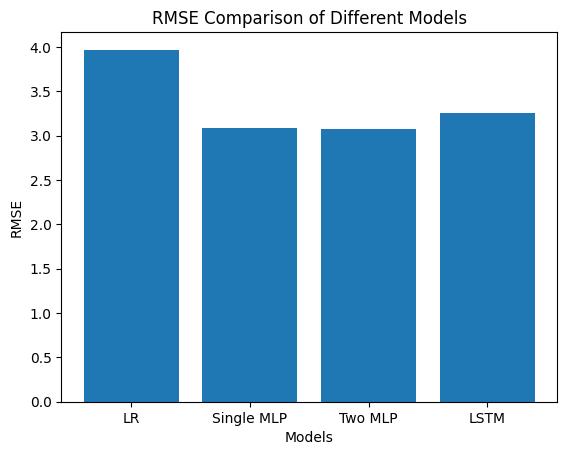

In [ ]:
# RMSE values for the four models
lstm_rmse = lstm_rmse
two_rmse_mlp = two_rmse_mlp
one_mlp_rmse = one_mlp_rmse
lr_rmse = lr_rmse

# Create a list of model names and corresponding RMSE values
model_names = ['LR', 'Single MLP', 'Two MLP', 'LSTM']
rmse_values = [lr_rmse, one_mlp_rmse, two_rmse_mlp, lstm_rmse]

# Plot the bar chart
plt.bar(model_names, rmse_values)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Different Models')

# Display the bar chart
plt.show()


Compare the performance of the models using MSE, MAE

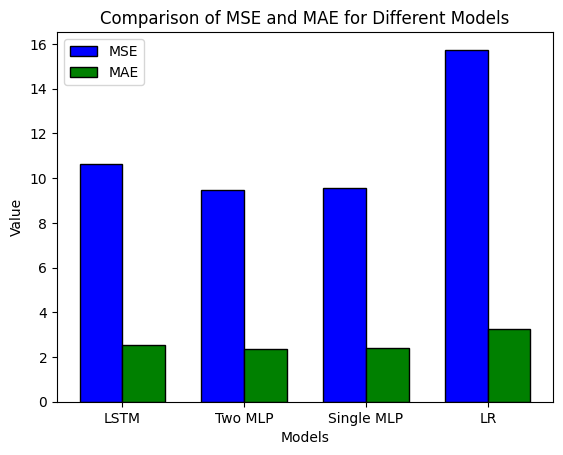

In [ ]:
# MSE values for the four models
mse_values = [lstm_mse, two_mse_mlp, one_mse_mlp, lr_mse]

# MAE values for the four models
mae_values = [lstm_mae, two_mae_mlp, one_mlp_mae, lr_mae]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r = np.arange(len(mse_values))

# Plot the bars for MSE
plt.bar(r, mse_values, color='b', width=bar_width, edgecolor='black', label='MSE')

# Plot the bars for MAE
plt.bar(r + bar_width, mae_values, color='g', width=bar_width, edgecolor='black', label='MAE')

# Add xticks and labels
plt.xticks(r + bar_width/2, ['LSTM', 'Two MLP', 'Single MLP', 'LR'])

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Value')
plt.title('Comparison of MSE and MAE for Different Models')
plt.legend()

# Display the bar chart
plt.show()


Compare R-squared values for all models

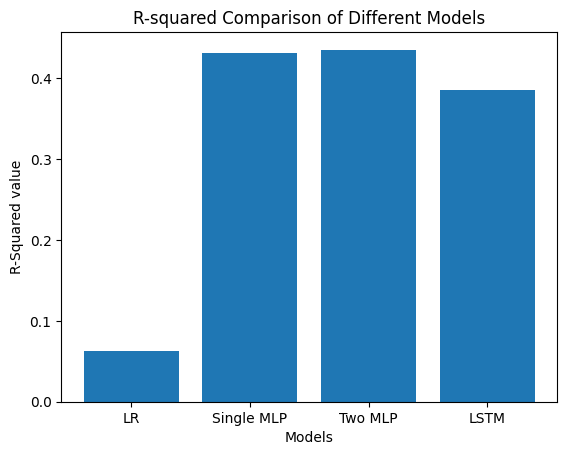

In [ ]:
# R2 values for the four models
lstm_rmse = lstm_rmse
two_rmse_mlp = two_rmse_mlp
one_mlp_rmse = one_mlp_rmse
lr_r2 = lr_r2

# Create a list of model names and corresponding R2 values
model_names = ['LR', 'Single MLP', 'Two MLP', 'LSTM']
rmse_values = [lr_r2, one_mlp_r2, two_r2_mlp, lstm_r2]

# Plot the bar chart
plt.bar(model_names, rmse_values)
plt.xlabel('Models')
plt.ylabel('R-Squared value')
plt.title('R-squared Comparison of Different Models')

# Display the bar chart
plt.show()
